# Introduction
## **WELCOME!!👋👋**

This notebook is the second exercise in the Learning Path for the Maven Course: [Build Multi-Agent Applications - A Bootcamp](https://maven.com/aggregate-intellect/llm-systems). Before proceeding, ensure you have reviewed and understood the concepts covered in the first notebook about building:

- A Retrieval-Augmented Generation (RAG) Application using LangChain

Let’s build our first agent application together!


## Objective 🎯:

The goal is to create an agent that:
- Create a comprehensive proposal for pitching a new weight loss drug to a pharma company (e.g. Bausch Health)
- Uses the web to search for relevant details

# Libraries Required for the Excercise

In [1]:
%%capture --no-stderr
!pip install -U --quiet langchain-community langchain_openai tavily-python langgraph

## Setup Required - APIs

In this notebook you'll be using OpenAI models for reasoning and generation, Tavily for searching facts online, langsmith for tracing and langgraph for agent orchestration.

In [3]:
import getpass
import os
from langsmith import utils

os.environ["LANGCHAIN_TRACING_V2"] = "true"
# define your langchain project name here
os.environ["LANGCHAIN_PROJECT"] = "maven-course-learning-path"

In [4]:
def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"Enter your {key}:")


_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
_set_env("TAVILY_API_KEY")

Enter your OPENAI_API_KEY:··········
Enter your LANGCHAIN_API_KEY:··········
Enter your TAVILY_API_KEY:··········


In [5]:
print('Is Tracing is enabled:', utils.tracing_is_enabled())

Is Tracing is enabled: True


## Imports

In [6]:
from typing import Literal
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, create_react_agent
from langchain_core.messages import HumanMessage

In [7]:
# First we initialize the model we want to use
model = ChatOpenAI(model="gpt-4o-mini")

# For this tutorial we will use prebuilt tool Tavily that provides search results for a given query
tools = [TavilySearchResults(max_results=3)]

# Define the graph
graph = create_react_agent(model, tools)

## Visualize Agent Workflow

In [8]:
def display_graph():
  from IPython.display import Image, display

  try:
      display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
  except Exception:
      # This requires some extra dependencies and is optional
      pass

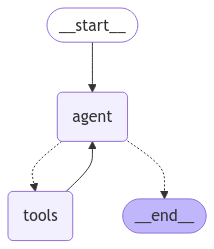

In [9]:
display_graph()

## Invoke Agent

In [10]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

def get_response(input_prompt):
  inputs = {"messages": [("user", input_prompt)]}
  print_stream(graph.stream(inputs, stream_mode="values"))

In [11]:
input_prompt = """You are an AI assistant tasked with creating a proposal for a new weight loss drug to pitch to Bausch Health.
Use the Tavily search tool to gather information about Bausch Health and the pharmaceutical industry.

Your proposal should include:
1. Executive Summary
2. Company Overview (Bausch Health)
3. Product Description
4. Market Analysis
5. Marketing Strategy
6. Financial Projections
   - Include estimated production costs
   - Projected sales and revenue
7. Conclusion

Ensure your proposal is well-structured, informative, and persuasive.
"""

In [12]:
get_response(input_prompt)

================================ Human Message =================================

You are an AI assistant tasked with creating a proposal for a new weight loss drug to pitch to Bausch Health.
Use the Tavily search tool to gather information about Bausch Health and the pharmaceutical industry.

Your proposal should include:
1. Executive Summary
2. Company Overview (Bausch Health)
3. Product Description
4. Market Analysis
5. Marketing Strategy
6. Financial Projections
   - Include estimated production costs
   - Projected sales and revenue
7. Conclusion

Ensure your proposal is well-structured, informative, and persuasive.

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_iSHhe11balehUnN0rmKjA53t)
 Call ID: call_iSHhe11balehUnN0rmKjA53t
  Args:
    query: Bausch Health overview
  tavily_search_results_json (call_KsasnmoSvTNtlctD3lMJDyOb)
 Call ID: call_KsasnmoSvTNtlctD3lMJDyOb
  Args:
    query: pharmaceutical

### Now let's try a question that doesn't need to use the Tavily search tool

In [13]:
get_response(input_prompt = 'What is An AI Agent')

================================ Human Message =================================

What is An AI Agent
================================== Ai Message ==================================

An AI agent is a system or program that uses artificial intelligence to perform tasks or make decisions autonomously or semi-autonomously. These agents can analyze data, learn from experiences, and interact with their environment or users. AI agents can vary in complexity and function, ranging from simple rule-based systems to advanced machine learning models capable of understanding natural language, recognizing images, or predicting outcomes.

Key characteristics of AI agents include:

1. **Autonomy**: They can operate without human intervention.
2. **Adaptability**: They can learn from data and improve their performance over time.
3. **Interactivity**: Many AI agents can communicate with users or other systems.
4. **Goal-oriented behavior**: They are designed to accomplish specific tasks or objectives.

## Build it From Scratch

In [14]:
# Define the tools for the agent to use
tools = [TavilySearchResults(max_results=2)]
tool_node = ToolNode(tools)

model = ChatOpenAI(model="gpt-4o",
                temperature=0).bind_tools(tools)

# Define the function that determines whether to continue or not
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

# Define the function that calls the model
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", 'agent')

# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
graph = workflow.compile()

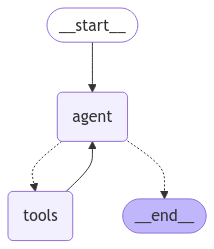

In [15]:
display_graph()

In [16]:
get_response(input_prompt)

================================ Human Message =================================

You are an AI assistant tasked with creating a proposal for a new weight loss drug to pitch to Bausch Health.
Use the Tavily search tool to gather information about Bausch Health and the pharmaceutical industry.

Your proposal should include:
1. Executive Summary
2. Company Overview (Bausch Health)
3. Product Description
4. Market Analysis
5. Marketing Strategy
6. Financial Projections
   - Include estimated production costs
   - Projected sales and revenue
7. Conclusion

Ensure your proposal is well-structured, informative, and persuasive.

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_yIvTQ616iEiZnz31lT0FR0OV)
 Call ID: call_yIvTQ616iEiZnz31lT0FR0OV
  Args:
    query: Bausch Health company overview
  tavily_search_results_json (call_uyi7wCC3K444ySCGcGUPVrBZ)
 Call ID: call_uyi7wCC3K444ySCGcGUPVrBZ
  Args:
    query: curren